# 🔵 **Dependencies**




In [1]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.1 MB/s eta 0:00:00


In [2]:
#for windows
!pip install -q soundfile
#for linux
!pip install -q sox

In [3]:
!pip install -q librosa

In [4]:
!pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 795.7 kB/s eta 0:00:00


# 🔵 **Imports**

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines

from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torchvision import models as extractor


import numpy  as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchmetrics as tm
import tqdm
import librosa
from collections import Counter

from IPython.display import Audio

In [6]:
!python --version

Python 3.10.12


In [7]:
for lib in [np, torch, torchaudio, torchtext, pd, tm, librosa]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu121
torchaudio --> 2.1.0+cu121
torchtext --> 0.16.0+cpu
pandas --> 1.5.3
torchmetrics --> 1.2.1
librosa --> 0.10.1


# 🔵 **Utils**

In [8]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [9]:
def to_sentence(preds, inputs):
  sentences_preds = []
  for pred in preds:
    indexes = pred.argmax(dim = -1).tolist()
    sentence = [ch_vocab.get_itos()[index] for index in indexes]
    sentence = ''.join(sentence).replace('<sos>', '')
    sentence = sentence.replace('<eos>', '')
    sentence = sentence.replace('<pad>', '')
    sentences_preds.append(''.join(sentence))

  sentences_inputs = []
  for input in inputs:
    indexes = input.tolist()
    sentence = [ch_vocab.get_itos()[index] for index in indexes]
    sentence = ''.join(sentence).replace('<sos>', '')
    sentence = sentence.replace('<eos>', '')
    sentence = sentence.replace('<pad>', '')
    sentences_inputs.append(sentence)

  return sentences_preds, sentences_inputs

In [10]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange


class CTCLoss(nn.Module):
    """Convenient wrapper for CTCLoss that handles log_softmax and taking input/target lengths."""

    def __init__(self, blank: int = 0) -> None:
        """Init method.

        Args:
            blank (int, optional): Blank token. Defaults to 0.
        """
        super().__init__()
        self.blank = blank

    def forward(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Forward method.

        Args:
            preds (torch.Tensor): Model predictions. Tensor of shape (batch, sequence_length, num_classes), or (N, T, C).
            targets (torch.Tensor): Target tensor of shape (batch, max_seq_length). max_seq_length may vary
                per batch.

        Returns:
            torch.Tensor: Loss scalar.
        """
        preds = preds.log_softmax(-1)
        batch, seq_len, classes = preds.shape
        preds = rearrange(preds, "n t c -> t n c") # since ctc_loss needs (T, N, C) inputs
        # equiv. to preds = preds.permute(1, 0, 2), if you don't use einops

        pred_lengths = torch.full(size=(batch,), fill_value=seq_len, dtype=torch.long)
        target_lengths = torch.count_nonzero(targets, axis=1)

        return F.ctc_loss(preds, targets, pred_lengths, pred_lengths, blank=self.blank, zero_infinity=True)

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [13]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

In [14]:
def print_stats(waveform, sample_rate = None, src = None):
  if src:
    print("_" * 10)
    print("Source:", src)
    print("_" * 10)

  if sample_rate:
    print("Sample Rate: ", sample_rate)

  print('Shape: ', tuple(waveform.shape))
  print('DType: ', waveform.dtype)
  print(f" - Max:   {waveform.max().item():6.3f}")
  print(f" - Min:   {waveform.min().item():6.3f}")
  print(f" - Mean:   {waveform.mean().item():6.3f}")
  print(f" - Std Dev:   {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [15]:
def plot_waveform(waveform, sample_rate, title = 'Waveform', xlim = None, ylim = None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth = 1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channels {c + 1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block = False)

In [16]:
def plot_spectrogram(specgram, title = None, ylabel = 'freq_bin'):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(T.AmplitudeToDB()(specgram), origin = 'lower')
  fig.colorbar(im, ax = axs)
  plt.show(block = False)

# 🔵 **Dataset**

## 🔵 **LoadDataset**

In [17]:
dataset = datasets.LJSPEECH('/content/', 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2', download = True)

100%|██████████| 2.56G/2.56G [00:39<00:00, 68.8MB/s]


In [18]:
len(dataset)

13100

In [19]:
import csv
with open('/content/LJSpeech-1.1/metadata.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    file = []
    for row in spamreader:
        file.append(' '.join(row))

In [20]:
csv_dataset = []
for sen in file:
  sent = sen.split('|')
  csv_dataset.append([sent[0], sent[1]])

In [21]:
data_df = pd.DataFrame(csv_dataset, columns = ['id', 'text'])
data_df

id                                               text
0      LJ001-0001  Printing, in the only sense with which we are ...
1      LJ001-0002                     in being comparatively modern.
2      LJ001-0003  For although the Chinese took impressions from...
3      LJ001-0004  produced the block books, which were the immed...
4      LJ001-0005  the invention of movable metal letters in the ...
...           ...                                                ...
13095  LJ050-0274  made certain recommendations which it believes...
13096  LJ050-0275  materially improve upon the procedures in effe...
13097  LJ050-0276  As has been pointed out, the Commission has no...
13098  LJ050-0277  with the active cooperation of the responsible...
13099  LJ050-0278  the recommendations we have here suggested wou...

[13100 rows x 2 columns]

In [22]:
class SplitData():
  def __init__(self, data_path):
    super(SplitData, self).__init__()
    data = np.loadtxt(data_path, dtype = str).tolist()
    self.ids = []
    for name in data:
      id = data_df[data_df['id'] == name].index.item()
      self.ids.append(id)

  def __call__(self, idx):
    return dataset[self.ids[idx]]

  def __len__(self):
    return len(self.ids)

In [23]:
train_set = SplitData('train.txt')
valid_set = SplitData('valid.txt')
test_set  = SplitData('test.txt')

In [24]:
len(train_set), len(valid_set), len(test_set)

(12500, 100, 500)

In [25]:
tokenizer = get_tokenizer('basic_english')

In [26]:
sentences = []
for i in range(len(train_set)):
  sentences.append(train_set(i)[2])

In [27]:
train_tokens = tokenizer(' '.join(sentences))
len(train_tokens)

238961

In [28]:
train_tokens[0:20]

['it',
 'has',
 'used',
 'other',
 'treasury',
 'law',
 'enforcement',
 'agents',
 'on',
 'special',
 'experiments',
 'in',
 'building',
 'and',
 'route',
 'surveys',
 'in',
 'places',
 'to',
 'which']

In [29]:
vocab  = build_vocab_from_iterator([train_tokens], min_freq = 0, specials = ['<unk>', '<pad>' ,'<sos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])
vocab_size = len(vocab.get_itos())
vocab_size

14420

In [30]:
token_list = vocab.get_itos()
characters = []
for token in token_list:
    chrc = list(token)
    for ch in chrc:
      characters.append(ch)

len(characters)

110573

In [31]:
ch_vocab  = build_vocab_from_iterator([characters], min_freq = 0, specials = ['<unk>', '<pad>' ,'<sos>', '<eos>', ' '])
ch_vocab.set_default_index(ch_vocab['<unk>'])
ch_vocab_size = len(ch_vocab.get_itos())
ch_vocab_size

65

## 🔵 **EDA**

In [ ]:
l_sentences = []
for sentence in sentences:
  l_sentences.append(len(tokenizer(sentence)))

In [ ]:
L_df = pd.DataFrame(l_sentences, index = sentences, columns = ['L'])
L_df

L
It has used other Treasury law enforcement agen...  25
to avail himself of his powers, as it was diffi...  32
Although Chief Rowley does not complain about t...  15
The three officers confirm that their primary c...  14
The tried and the untried, young and old, were ...  13
...                                                 ..
In another part seven persons met their death b...  11
However, the 1964 to 65 budget request was subm...  13
It is the American people themselves who expect...  20
Handwriting experts, Alwyn Cole of the Treasury...  18
The prisoner was conveyed without delay to the ...  28

[12500 rows x 1 columns]

In [ ]:
L_df.describe()

L
count  12500.000000
mean      19.116880
std        6.699236
min        1.000000
25%       14.000000
50%       19.000000
75%       24.000000
max       44.000000

In [ ]:
word_counts = Counter()
for word in train_tokens:
    word_counts.update([word])

In [ ]:
N_word = pd.DataFrame(word_counts.values(), index = word_counts.keys(), columns = ['N']).sort_values('N')
N_word.describe()

N
count  14416.000000
mean      16.576096
std      246.406432
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max    17474.000000

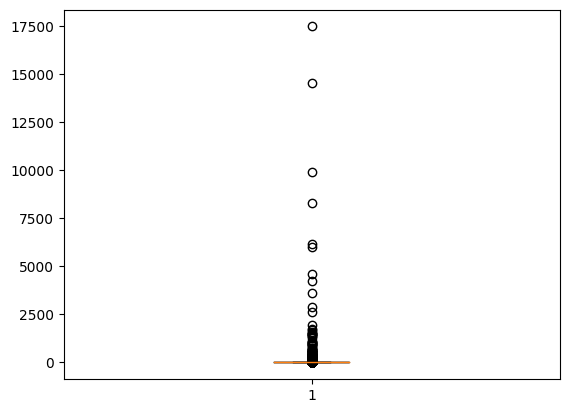

In [ ]:
plt.boxplot(N_word)
plt.show()

In [ ]:
N_word[N_word['N']>5000]

N
to    6028
and   6165
of    8319
.     9905
,    14518
the  17474

In [ ]:
N_word[N_word['N']<2]

N
alwyn             1
provocation       1
dissolution       1
smug              1
happening         1
...              ..
better-regulated  1
oversee           1
nominated         1
bravo             1
8-week            1

[5921 rows x 1 columns]

In [ ]:
waveform, sample_rate, text, _  = train_set(0)

Sample Rate:  22050
Shape:  (1, 217501)
DType:  torch.float32
 - Max:    0.474
 - Min:   -0.413
 - Mean:   -0.000
 - Std Dev:    0.061

tensor([[0.0003, 0.0004, 0.0003,  ..., 0.0013, 0.0012, 0.0002]])



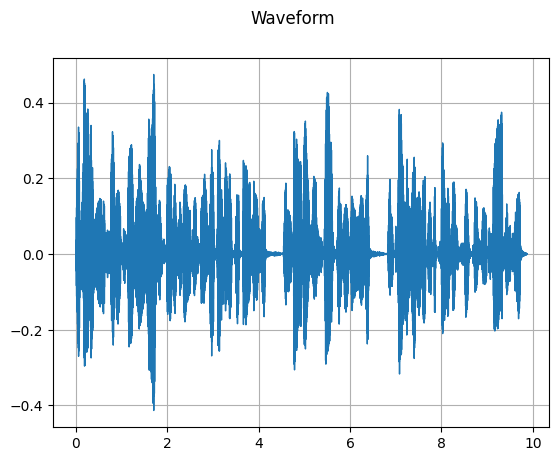

In [ ]:
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
mel_spectro = T.MelSpectrogram(sample_rate, n_fft = 1024, hop_length = 128, n_mels = 150)
spec = mel_spectro(waveform)

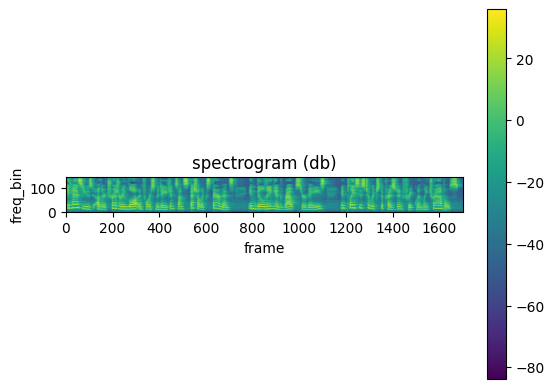

In [ ]:
plot_spectrogram(spec[0])

In [ ]:
text

'It has used other Treasury law enforcement agents on special experiments in building and route surveys in places to which the President frequently travels.'

In [ ]:
Audio(waveform.numpy(), rate = sample_rate)

In [ ]:
wav_info = []
for i in range(len(train_set)):
  sample, sample_rate, _, _  = train_set(i)
  wav_info.append([sample.shape[1]/sample_rate, sample.mean().item(), sample.std().item()])

In [ ]:
wav_df = pd.DataFrame(wav_info, columns = ['time', 'mean', 'std'])
wav_df.describe()

time          mean           std
count  12500.000000  12500.000000  12500.000000
mean       6.576561      0.000009      0.066083
std        2.182036      0.000008      0.009615
min        1.110068     -0.000074      0.032051
25%        4.987800      0.000004      0.059395
50%        6.764127      0.000008      0.065272
75%        8.389524      0.000013      0.071681
max       10.096190      0.000068      0.130990

### average mean = 0.000009 ||| average std = 0.066083

## 🔵 **CustomDataset**




In [38]:
transform = nn.Sequential(T.MelSpectrogram(sample_rate = 22050, n_fft = 256, hop_length = 512, n_mels = 64),
                          T.FrequencyMasking(freq_mask_param = 5),
                          T.TimeMasking(time_mask_param = 10, p = 0.5))

In [39]:
class LJSpeechDataset(Dataset):
  def __init__(self, dataset, tokenizer, vocab, transform = None):
    super(LJSpeechDataset, self).__init__()
    self.dataset   = dataset
    self.tokenizer = tokenizer
    self.vocab     = vocab
    self.transform = transform

  def __getitem__(self, idx):
    wavform, sample_rate, text, _ = self.dataset(idx)

    if self.transform:
      input = self.transform(wavform)
    else:
      input = T.MelSpectrogram(sample_rate, n_fft = 256, hop_length = 512, n_mels = 64)(wavform)

    characters = list(text)
    characters.append('<eos>')
    characters.insert(0, '<sos>')
    text_idx = [self.vocab[character.lower()] for character in characters]
    target   = torch.LongTensor(text_idx)

    return input, target

  def __len__(self):
    return len(self.dataset)

In [40]:
train_dataset = LJSpeechDataset(train_set, tokenizer, ch_vocab, transform)
valid_dataset = LJSpeechDataset(valid_set, tokenizer, ch_vocab, None)
test_dataset  = LJSpeechDataset(test_set, tokenizer , ch_vocab, None)

In [41]:
spec, taregt = train_dataset[0]
spec.shape, taregt

(torch.Size([1, 64, 425]),
 tensor([ 2,  6, 11,  4, 20, 10,  7,  4, 16,  7,  5, 14,  4, 12, 11, 20,  5,  9,
          4, 11,  9,  5, 10,  7, 16,  9, 22,  4, 13, 10, 25,  4,  5,  8, 23, 12,
          9, 15,  5, 19,  5,  8, 11,  4, 10, 18,  5,  8, 11,  7,  4, 12,  8,  4,
          7, 17,  5, 15,  6, 10, 13,  4,  5, 28, 17,  5,  9,  6, 19,  5,  8, 11,
          7,  4,  6,  8,  4, 21, 16,  6, 13, 14,  6,  8, 18,  4, 10,  8, 14,  4,
          9, 12, 16, 11,  5,  4,  7, 16,  9, 24,  5, 22,  7,  4,  6,  8,  4, 17,
         13, 10, 15,  5,  7,  4, 11, 12,  4, 25, 20,  6, 15, 20,  4, 11, 20,  5,
          4, 17,  9,  5,  7,  6, 14,  5,  8, 11,  4, 23,  9,  5, 32, 16,  5,  8,
         11, 13, 22,  4, 11,  9, 10, 24,  5, 13,  7, 57,  3]))

## 🔵 **Visualize**

In [44]:
import random
def visualize_random_sample(n, dataset, vocab):

  n_random_idx = random.sample(range(0, len(dataset) - 1), n)

  audios = []
  texts  = []
  for idx in n_random_idx:

      spec, text_idx = dataset[idx]
      wavform = T.InverseMelScale(n_stft = 512, n_mels = 64, sample_rate = 22050)(spec[0])
      audios.append(Audio(wavform, rate = 22050))
      display(plot_spectrogram(spec[0]))
      #display(Audio(wavform, rate = 22050))


      text = [vocab.get_itos()[index] for index in text_idx.tolist()]
      texts.append(text)
      print(''.join(text))

  return audios, texts

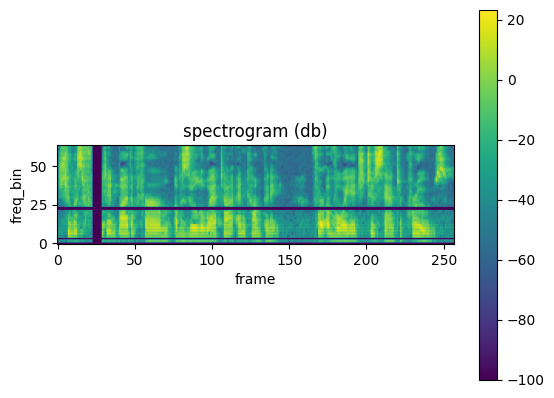

None

<sos>she was freighted by the firm of zulueta and co. for a voyage to santa cruz.<eos>


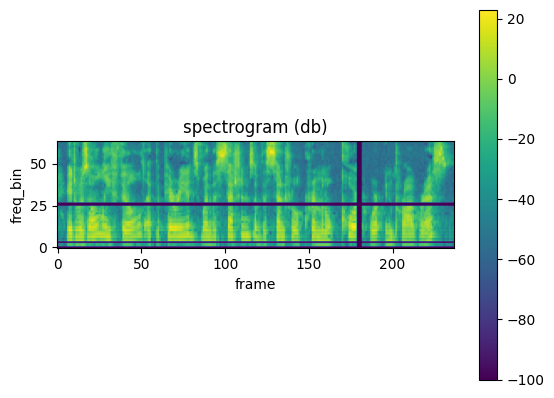

None

<sos>it was only filled at the periods when the sessions of the central criminal court were in progress<unk><eos>


In [45]:
audios, texts = visualize_random_sample(2, train_dataset, ch_vocab)

## 🔵 **DataLoader**

In [46]:
def collate_fn(batch):
  samples = [b[0][0].t() for b in batch]
  samples = pad_sequence(samples, batch_first = True, ).unsqueeze(1)
  targets  = [b[1] for b in batch]
  targets  = pad_sequence(targets, batch_first = True, padding_value = vocab['<pad>'])

  return samples, targets

In [47]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = False, collate_fn = collate_fn)
test_loader  = DataLoader(test_dataset , batch_size = 32, shuffle = False, collate_fn = collate_fn)

In [48]:
input, target = next(iter(train_loader))

In [49]:
input.shape, target.shape

(torch.Size([32, 1, 425, 64]), torch.Size([32, 159]))

# 🔵 **Model**

In [50]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [51]:
class Speech2Text(nn.Module):
  def __init__(self, num_encoder_layer, num_decoder_layer, nhead, dim_forward, dropout, batch_first,
               vocab_size, embedding_dim, c = 8, freq = 64):
    super(Speech2Text, self).__init__()

    self.d_model = int(c * 8 * freq / 8)
    #self.pos_encoder = PositionalEncoding(embedding_dim, dropout)

    self.feature_extractor = nn.Sequential(nn.Conv2d(1, c, (3, 3), stride = (1, 1), padding = (1, 1)),
                                           nn.BatchNorm2d(c),
                                           nn.ReLU(),
                                           nn.Conv2d(c, c * 2, (3, 3), stride = (1, 1), padding = (1, 1)),
                                           nn.BatchNorm2d(c * 2),
                                           nn.ReLU(),
                                           nn.MaxPool2d(2, 2),
                                           nn.Conv2d(c * 2, c * 4, (3, 3), stride = (1, 1), padding = (1, 1)),
                                           nn.BatchNorm2d(c * 4),
                                           nn.ReLU(),
                                           nn.MaxPool2d(2, 2),
                                           nn.Conv2d(c * 4, c * 8, (3, 3), stride = (1, 1), padding = (1, 1)),
                                           nn.BatchNorm2d(c * 8),
                                           nn.ReLU(),
                                           nn.MaxPool2d(2, 2))
    #self.fc = nn.Linear(int(c * 2 * freq / 4), self.d_model)

    self.transformer = nn.Transformer(self.d_model, nhead, num_encoder_layer, num_decoder_layer, dim_forward, dropout, batch_first = batch_first)

    self.embedding  = nn.Embedding(vocab_size, embedding_dim, ch_vocab['<pad>'])
    self.dim_change = nn.Linear(embedding_dim, self.d_model)

    self.cls_head = nn.Linear(self.d_model, vocab_size)

  #def init_weights(self) -> None:
  #      initrange = 0.1
  #      self.embedding.weight.data.uniform_(-initrange, initrange)
  #      self.fc.bias.data.zero_()
  #      self.fc.weight.data.uniform_(-initrange, initrange)

  def forward(self, audio, tokens):
    y = self.Encoder(audio)
    y = self.Decoder(y, tokens)
    return y

  def Encoder(self, audio):
    y = self.feature_extractor(audio)
    y = y.permute(0, 2, 1, 3)
    y = y.flatten(2)
    #y = self.fc(y)
    y = self.transformer.encoder(y)

    return y

  def Decoder(self, encoder_out, tokens):
    y = self.embedding(tokens) #* math.sqrt(self.d_model)
    y = self.dim_change(y)
    #y = self.pos_encoder(y)
    tgt_mask = self.transformer.generate_square_subsequent_mask(y.shape[1])
    y = self.transformer.decoder(y, encoder_out,tgt_mask = tgt_mask)
    y = self.cls_head(y)

    return y


In [52]:
model = Speech2Text(1, 1, 1, 10, 0.1, True, ch_vocab_size, 10).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [53]:
num_trainable_params(model)

3.244815

In [54]:
audio, tokens = next(iter(train_loader))

In [55]:
audio.shape, tokens.shape

(torch.Size([32, 1, 429, 64]), torch.Size([32, 157]))

In [56]:
model(audio.to(device), tokens[:, 0:-1].to(device)).shape

torch.Size([32, 156, 65])

# 🔵 **Config**


In [57]:
loss_func = nn.CrossEntropyLoss()
metric = tm.text.WordErrorRate().to(device)

# 🔵 **Train**

In [58]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, shedular, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for audios, tokens in tepoch:
      if epoch or epoch == 0:
        tepoch.set_description(f'Epoch {epoch}')


      audios  = audios.to(device)
      tokens   = tokens.to(device)

      outputs = model(audios, tokens[:, 0:-1])

      loss = loss_fn(outputs.permute(0, 2, 1), tokens[:, 1:])

      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
      if shedular:
        shedular.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      #pred_sentences, input_sentences = to_sentence(outputs, tokens)
      #metric.update(pred_sentences, input_sentences)


      tepoch.set_postfix(loss=loss_train.avg, WER=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔵 **Evaluate**

In [59]:
def evaluate(model, data_loader, loss_fn, metric):
  model.eval()
  metric.reset()

  loss_valid = AverageMeter()

  for audios, tokens in data_loader:

    audios = audios.to(device)
    tokens = tokens.to(device)
    with torch.no_grad():
      outputs = model(audios, tokens[:, 0:-1])

    loss = loss_fn(outputs.permute(0, 2, 1), tokens[:, 1:])
    loss_valid.update(loss)
    pred_sentences, input_sentences = to_sentence(outputs, tokens)

    metric.update(pred_sentences, input_sentences)

  print(f'Loss : {loss_valid.avg.item()}, WER : {metric.compute().item()}')

  return loss_valid.avg.item(), metric.compute().item()

# 🔵 **Training Peocess**

## 🔵 **Step1**

In [ ]:
audios, tokens = next(iter(train_loader))
audios.shape, tokens.shape

(torch.Size([32, 1, 296, 20]), torch.Size([32, 167]))

In [ ]:
model = Speech2Text(1, 1, 1, 10, 0.1, True, ch_vocab_size, 10).to(device)
num_trainable_params(model)

0.141865

In [ ]:
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])

In [ ]:
pred = model(audios.to(device), tokens[:, 0:-1].to(device))
pred.shape

torch.Size([32, 166, 65])

In [ ]:
pred.shape, tokens[:, 1:].shape

(torch.Size([32, 166, 65]), torch.Size([32, 166]))

In [ ]:
loss_func(pred.permute(0, 2, 1), tokens[:, 1:].to(device))

tensor(4.4652, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

## 🔵 **Step2**

In [ ]:
torch.cuda.empty_cache()
model = Speech2Text(4, 1, 128, 512, 0.1, True, ch_vocab_size, 256, 16).to(device)
num_trainable_params(model)

9.222817

In [ ]:
#optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.001, betas = [0.9, 0.99])
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 1000, eta_min = 1e-6)
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
#loss_func = CTCLoss(blank = vocab['<pad>'])
metric    = tm.text.WordErrorRate().to(device)

In [ ]:
sub_set, _ = random_split(train_dataset, (10, len(train_dataset) - 10))
len(sub_set)

10

In [ ]:
sub_loader = DataLoader(sub_set, batch_size = 1, shuffle = True, collate_fn = collate_fn)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, sub_loader, loss_func, optimizer, shedular, metric, epoch)

Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 19.96batch/s, WER=nan, loss=0.365]


## 🔵 **Step3**

In [ ]:
num_epochs = 5
lr_list    = [0.7, 0.5, 0.2]
results    = []

for lr in lr_list:
  sub_result = []
  print(f'LR={lr}')

  model = Speech2Text(2, 2, 64, 512, 0.1, True, ch_vocab_size, 256, 16).to(device)

  optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
  loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
  metric    = tm.text.WordErrorRate().to(device)

  for epoch in range(num_epochs):
    model, train_loss, _ = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, epoch)

    if epoch == 0:
      sub_result.append(train_loss)
    if epoch == 4:
      sub_result.append(train_loss)

  results.append(sub_result)

  print()

LR=0.7


Epoch 4: 100%|██████████| 391/391 [03:52<00:00,  1.68batch/s, WER=nan, loss=2.05]



LR=0.5


Epoch 4: 100%|██████████| 391/391 [03:56<00:00,  1.65batch/s, WER=nan, loss=2.01]



LR=0.2


Epoch 4: 100%|██████████| 391/391 [03:49<00:00,  1.71batch/s, WER=nan, loss=1.96]

In [ ]:
pd.DataFrame(results, columns = ['start', 'stop'], index = lr_list)

start      stop
0.7  2.611793  2.052843
0.5  2.479848  2.011394
0.2  2.434813  1.960108

## 🔵 **Step4**

In [ ]:
lr_list = [0.2]
wd_list = [0, 1e-4,  1e-5, 1e-6]
result  = []
indexes = []

for lr in lr_list:
  for wd in wd_list:

    print(f'LR = {lr}, Weight_decay = {wd}')
    indexes.append(f'LR = {lr}, Weight_decay = {wd}')

    sub_result = []

    model = Speech2Text(2, 2, 64, 512, 0.1, True, ch_vocab_size, 256, 16).to(device)

    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
    loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
    metric    = tm.text.WordErrorRate().to(device)

    for i in range(4):
      model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, i)
      valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

      if i == 0:
        sub_result.append(train_loss)
        sub_result.append(valid_loss)
      if i == 3:
        sub_result.append(train_loss)
        sub_result.append(valid_loss)

    result.append(sub_result)
    torch.save(model, f'/content/models-step4/model*{lr}*{wd}.pt')
    print('model saved!')
    print('---------------------------------------------')

LR = 0.2, Weight_decay = 0


Epoch 0:   0%|          | 0/391 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric WordErrorRate was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 0: 100%|██████████| 391/391 [03:38<00:00,  1.79batch/s, WER=nan, loss=2.43]


Loss : 2.3276357650756836, WER : 1.0662614107131958


Epoch 1: 100%|██████████| 391/391 [03:37<00:00,  1.80batch/s, WER=nan, loss=2.26]


Loss : 2.123357057571411, WER : 1.0899696350097656


Epoch 2: 100%|██████████| 391/391 [03:38<00:00,  1.79batch/s, WER=nan, loss=2.12]


Loss : 2.0062334537506104, WER : 1.043161153793335


Epoch 3: 100%|██████████| 391/391 [03:38<00:00,  1.79batch/s, WER=nan, loss=2.03]


Loss : 1.9145774841308594, WER : 1.1665652990341187
model saved!
---------------------------------------------
LR = 0.2, Weight_decay = 0.0001


Epoch 0: 100%|██████████| 391/391 [03:36<00:00,  1.80batch/s, WER=nan, loss=2.44]


Loss : 2.3313069343566895, WER : 1.3477203845977783


Epoch 1: 100%|██████████| 391/391 [03:34<00:00,  1.83batch/s, WER=nan, loss=2.27]


Loss : 2.1643941402435303, WER : 1.2285714149475098


Epoch 2: 100%|██████████| 391/391 [03:33<00:00,  1.83batch/s, WER=nan, loss=2.12]


Loss : 2.0288619995117188, WER : 1.013373851776123


Epoch 3: 100%|██████████| 391/391 [03:34<00:00,  1.82batch/s, WER=nan, loss=2.03]


Loss : 1.9261761903762817, WER : 1.083282709121704
model saved!
---------------------------------------------
LR = 0.2, Weight_decay = 1e-05


Epoch 0: 100%|██████████| 391/391 [03:33<00:00,  1.83batch/s, WER=nan, loss=2.44]


Loss : 2.3453733921051025, WER : 1.295440673828125


Epoch 1: 100%|██████████| 391/391 [03:34<00:00,  1.83batch/s, WER=nan, loss=2.27]


Loss : 2.166126251220703, WER : 1.2559270858764648


Epoch 2: 100%|██████████| 391/391 [03:43<00:00,  1.75batch/s, WER=nan, loss=2.12]


Loss : 2.0029327869415283, WER : 1.106990933418274


Epoch 3: 100%|██████████| 391/391 [03:33<00:00,  1.83batch/s, WER=nan, loss=2.03]


Loss : 1.9120945930480957, WER : 1.0389057397842407
model saved!
---------------------------------------------
LR = 0.2, Weight_decay = 1e-06


Epoch 0: 100%|██████████| 391/391 [03:33<00:00,  1.83batch/s, WER=nan, loss=2.44]


Loss : 2.34263277053833, WER : 1.0723403692245483


Epoch 1: 100%|██████████| 391/391 [03:43<00:00,  1.75batch/s, WER=nan, loss=2.27]


Loss : 2.181631565093994, WER : 1.373860239982605


Epoch 2: 100%|██████████| 391/391 [03:40<00:00,  1.77batch/s, WER=nan, loss=2.13]


Loss : 2.0136353969573975, WER : 1.119756817817688


Epoch 3: 100%|██████████| 391/391 [03:28<00:00,  1.88batch/s, WER=nan, loss=2.03]


Loss : 1.9416351318359375, WER : 1.077203631401062
model saved!
---------------------------------------------


In [ ]:
pd.DataFrame(result, index = indexes, columns = ['start train loss',
                                                 'start valid loss',
                                                 'stop train loss',
                                                 'stop valid loss'])

start train loss  start valid loss  \
LR = 0.2, Weight_decay = 0               2.430844          2.327636   
LR = 0.2, Weight_decay = 0.0001          2.436705          2.331307   
LR = 0.2, Weight_decay = 1e-05           2.439864          2.345373   
LR = 0.2, Weight_decay = 1e-06           2.440801          2.342633   

                                 stop train loss  stop valid loss  
LR = 0.2, Weight_decay = 0              2.030211         1.914577  
LR = 0.2, Weight_decay = 0.0001         2.027344         1.926176  
LR = 0.2, Weight_decay = 1e-05          2.029161         1.912095  
LR = 0.2, Weight_decay = 1e-06          2.034473         1.941635

## 🔵 **Step5**

In [ ]:
model = torch.load('/content/models-step4/model*0.2*1e-05.pt').to(device)

In [ ]:
lr = 0.2
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
metric    = tm.text.WordErrorRate().to(device)

In [ ]:
for i in range(5):
      model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, i)
      valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

Epoch 0:   0%|          | 0/391 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric WordErrorRate was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 0: 100%|██████████| 391/391 [03:45<00:00,  1.73batch/s, WER=nan, loss=1.96]


Loss : 1.8639010190963745, WER : 1.1246200799942017


Epoch 1: 100%|██████████| 391/391 [03:42<00:00,  1.76batch/s, WER=nan, loss=1.91]


Loss : 1.7894606590270996, WER : 1.0601823329925537


Epoch 2: 100%|██████████| 391/391 [03:32<00:00,  1.84batch/s, WER=nan, loss=1.85]


Loss : 1.749413251876831, WER : 1.0437690019607544


Epoch 3: 100%|██████████| 391/391 [03:33<00:00,  1.83batch/s, WER=nan, loss=1.8]


Loss : 1.7198188304901123, WER : 1.093009114265442


Epoch 4: 100%|██████████| 391/391 [03:32<00:00,  1.84batch/s, WER=nan, loss=1.76]


Loss : 1.645408034324646, WER : 0.9902735352516174


## 🔵 **Main Loop**

In [65]:
torch.cuda.empty_cache()

In [71]:
set_seed(42)
model = Speech2Text(2, 2, 64, 512, 0.1, True, ch_vocab_size, 256, 16).to(device)
num_trainable_params(model)

29.859489

In [72]:
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, collate_fn = collate_fn, num_workers = 2)

In [73]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist  =[], []
best_metric = torch.inf
best_loss   = torch.inf

In [74]:
lr = 0.2
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = wd, momentum = 0.9)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20000, eta_min = 1e-7)
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
#loss_func = nn.CTCLoss(blank = vocab['<pad>'])
#loss_func = CTCLoss(blank = vocab['<pad>'])
metric    = tm.text.WordErrorRate().to(device)

In [76]:
set_seed(42)

start, stop = 21, 50
wait = 0

for i in range(start, stop):

  model, train_loss, train_metric = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, i)
  valid_loss, valid_metric        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  valid_loss_hist.append(valid_loss)
  train_metric_hist.append(train_metric)
  valid_metric_hist.append(valid_metric)

  if valid_loss<best_loss:

    torch.save(model, 'best_model.pt')
    print('model saved!')
    wait = 0
    best_loss = valid_loss

  if valid_metric<best_metric:
    torch.save(model, 'best_model.pt')
    print('model saved!')
    wait = 0
    best_metric = valid_metric

  if valid_loss>best_loss and valid_metric>best_metric:
    wait += 1
    if wait >= 3 and i >= 0:
      lr = 0.3 * lr
      optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = wd, momentum = 0.9)
      wait = 0

Epoch 21: 100%|██████████| 391/391 [03:04<00:00,  2.12batch/s, WER=nan, loss=0.882]


Loss : 1.5834883451461792, WER : 0.9355623126029968


Epoch 22: 100%|██████████| 391/391 [03:05<00:00,  2.11batch/s, WER=nan, loss=0.854]


Loss : 1.2494065761566162, WER : 0.8887537717819214


Epoch 23: 100%|██████████| 391/391 [03:07<00:00,  2.09batch/s, WER=nan, loss=0.833]


Loss : 1.6833548545837402, WER : 0.9234042763710022


Epoch 24: 100%|██████████| 391/391 [03:03<00:00,  2.13batch/s, WER=nan, loss=0.818]


Loss : 2.0692617893218994, WER : 0.9604862928390503


Epoch 25: 100%|██████████| 391/391 [03:03<00:00,  2.13batch/s, WER=nan, loss=0.748]


Loss : 1.1913038492202759, WER : 0.8449848294258118
model saved!


Epoch 26: 100%|██████████| 391/391 [03:04<00:00,  2.12batch/s, WER=nan, loss=0.734]


Loss : 0.8106632232666016, WER : 0.7647416591644287
model saved!
model saved!


Epoch 27: 100%|██████████| 391/391 [03:02<00:00,  2.14batch/s, WER=nan, loss=0.724]


Loss : 1.160216212272644, WER : 0.8838905692100525


Epoch 28: 100%|██████████| 391/391 [03:04<00:00,  2.11batch/s, WER=nan, loss=0.717]


Loss : 0.7881036996841431, WER : 0.7373860478401184
model saved!
model saved!


Epoch 29: 100%|██████████| 391/391 [03:02<00:00,  2.15batch/s, WER=nan, loss=0.709]


Loss : 1.0937669277191162, WER : 0.8541033267974854


Epoch 30: 100%|██████████| 391/391 [03:05<00:00,  2.11batch/s, WER=nan, loss=0.701]


Loss : 1.686622977256775, WER : 0.9142857193946838


Epoch 31: 100%|██████████| 391/391 [03:09<00:00,  2.07batch/s, WER=nan, loss=0.695]


Loss : 0.7374051213264465, WER : 0.7094224691390991
model saved!
model saved!


Epoch 32: 100%|██████████| 391/391 [03:07<00:00,  2.09batch/s, WER=nan, loss=0.69]


Loss : 1.0974477529525757, WER : 0.8194528818130493


Epoch 33: 100%|██████████| 391/391 [03:06<00:00,  2.10batch/s, WER=nan, loss=0.681]


Loss : 0.9885009527206421, WER : 0.8352583646774292


Epoch 34: 100%|██████████| 391/391 [03:03<00:00,  2.13batch/s, WER=nan, loss=0.673]


Loss : 0.8723785281181335, WER : 0.7835866212844849


Epoch 35: 100%|██████████| 391/391 [03:03<00:00,  2.13batch/s, WER=nan, loss=0.646]


Loss : 0.9707789421081543, WER : 0.7951367497444153


Epoch 36: 100%|██████████| 391/391 [03:05<00:00,  2.11batch/s, WER=nan, loss=0.636]


Loss : 1.2275406122207642, WER : 0.8455926775932312


Epoch 37: 100%|██████████| 391/391 [03:03<00:00,  2.13batch/s, WER=nan, loss=0.638]


Loss : 1.2491281032562256, WER : 0.8455926775932312


Epoch 38: 100%|██████████| 391/391 [03:03<00:00,  2.13batch/s, WER=nan, loss=0.626]


Loss : 0.8308696746826172, WER : 0.7562310099601746


Epoch 39: 100%|██████████| 391/391 [03:07<00:00,  2.09batch/s, WER=nan, loss=0.62]


Loss : 1.106485366821289, WER : 0.8218845129013062


Epoch 40: 100%|██████████| 391/391 [03:02<00:00,  2.14batch/s, WER=nan, loss=0.617]


Loss : 1.3702142238616943, WER : 0.8662614226341248


Epoch 41: 100%|██████████| 391/391 [03:03<00:00,  2.14batch/s, WER=nan, loss=0.611]


Loss : 0.9543176889419556, WER : 0.7878419160842896


Epoch 42: 100%|██████████| 391/391 [03:04<00:00,  2.12batch/s, WER=nan, loss=0.646]


Loss : 0.9206001162528992, WER : 0.7805471420288086


Epoch 43: 100%|██████████| 391/391 [03:02<00:00,  2.14batch/s, WER=nan, loss=0.647]


Loss : 0.8973655104637146, WER : 0.7793313264846802


Epoch 44: 100%|██████████| 391/391 [03:05<00:00,  2.10batch/s, WER=nan, loss=0.644]


Loss : 1.0798419713974, WER : 0.8151975870132446


Epoch 45: 100%|██████████| 391/391 [03:03<00:00,  2.14batch/s, WER=nan, loss=0.646]


Loss : 1.5178663730621338, WER : 0.8924012184143066


Epoch 46: 100%|██████████| 391/391 [03:02<00:00,  2.15batch/s, WER=nan, loss=0.645]


Loss : 1.0260857343673706, WER : 0.7993921041488647


Epoch 47: 100%|██████████| 391/391 [03:05<00:00,  2.10batch/s, WER=nan, loss=0.646]


Loss : 0.971940815448761, WER : 0.7939209938049316


Epoch 48: 100%|██████████| 391/391 [02:59<00:00,  2.17batch/s, WER=nan, loss=0.644]


Loss : 0.8324657082557678, WER : 0.7568389177322388


Epoch 49: 100%|██████████| 391/391 [03:00<00:00,  2.17batch/s, WER=nan, loss=0.646]


Loss : 1.059761881828308, WER : 0.8127659559249878


### 🔵 **Plot**

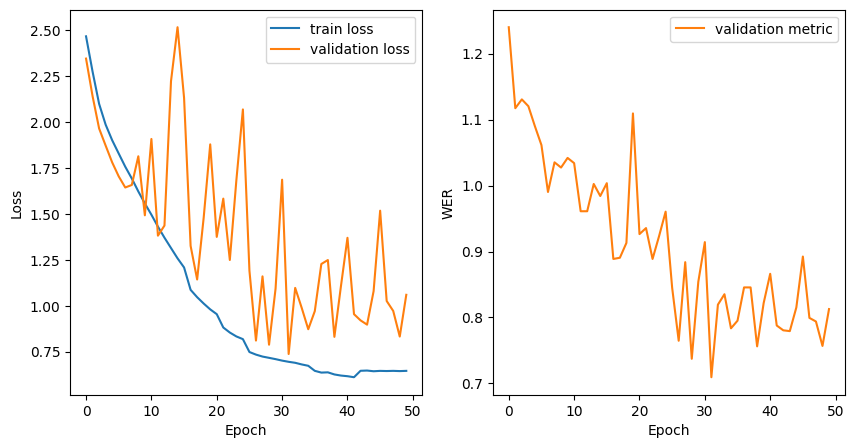

In [77]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(stop), train_loss_hist, label = 'train loss')
plt.plot(range(stop), valid_loss_hist, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_metric_hist)#, label = 'train metric')
plt.plot(valid_metric_hist, label = 'validation metric')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.legend()
plt.show()

# 🔵 **Test**

In [78]:
model = torch.load('best_model.pt').to(device).eval()

In [79]:
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 0.7126343846321106, WER : 0.7173241376876831


# 🔵 **Speech2Text**

In [80]:
model = torch.load('best_model.pt').to(device).eval()

In [85]:
def speech2text(model, wavform, sample_rate, vocab, real_text, metric):
  model.eval()

  input = T.MelSpectrogram(sample_rate, n_fft = 256, hop_length = 512, n_mels = 64)(wavform).unsqueeze(0).permute(0, 1, 3, 2)

  tokens = torch.LongTensor([vocab['<sos>']]).unsqueeze(0)
  end = False
  counter = 0
  while(end == False):

    with torch.no_grad():
      new_token = model(input.to(device), tokens.to(device))[:, -1, :]

    index = new_token.argmax(dim = -1)

    if index.item() == vocab['.'] or index.item() == vocab['<eos>']:
      tokens = torch.cat([tokens, torch.LongTensor([index.item()]).unsqueeze(0)], dim = -1)
      end = True

    elif counter == 200:
      end = True

    else:
      tokens = torch.cat([tokens, torch.LongTensor([index.item()]).unsqueeze(0)], dim = -1)
      counter += 1

  text = ''.join([vocab.get_itos()[idx] for idx in tokens.squeeze().tolist()])
  text = text.replace('<sos>', '')
  text = text.replace('<eos>', '')
  real_text = ' '.join(tokenizer(real_text))

  display(Audio(wavform, rate = sample_rate))
  display(text)
  print()
  display(real_text)
  print()
  display(metric([text], [real_text]))

In [89]:
idx_list = [1, 2, 30, 400, 450, 255]
for idx in idx_list:
  wavform, sample_rate, real_text, _ = test_set(idx)
  speech2text(model, wavform, sample_rate, ch_vocab, real_text, metric)

'the secret service was greatly in foul transfer it with a regularly involved that it which was very bridddead by riddelieved that at it it wof a he present parent.'

'the secret service believed that it was very doubtful that any president would ride regularly in a vehicle with a fixed top , even though transparent .'

tensor(0.9630, device='cuda:0')

'the two me and the between in the bettween ind the bethen peyes and located the house and the house locand and nin the beven the house and outher hous.'

'between the hours of 8 and 9 p . m . they were occupied with the children in the bedrooms located at the extreme east end of the house .'

tensor(0.9333, device='cuda:0')

'we all not of few such alloways to remouning the day to such all destron of few service to ron around in new ndithed day bated the day.'

'we will not allow ourselves to run around in new circles of futile discussion and debate , always postponing the day of decision .'

tensor(0.9583, device='cuda:0')

'hosty considered the information to be notentent to be a considered the information to the reported statement to the reported statement.'

"hosty considered the information to be , quote , stale , unquote , by that time , and did not attempt to verify oswald ' s reported statement ."

tensor(0.7241, device='cuda:0')

'mr.'

"mr . buxton ' s friends at once paid the forty shillings , and the boy was released ."

tensor(1., device='cuda:0')

'lack disappline many mans to other diditure to other didid the jail, who other distil for the jail, who mans distill for the prisoners of prisoners,'

'the lax discipline maintained in newgate was still further deteriorated by the presence of two other classes of prisoners who ought never to have been inmates of such a jail .'

tensor(0.9032, device='cuda:0')